In [2]:
import collections
import fasttext
import json
import gzip
import nltk
import pickle
import random
import scipy.sparse
import sys
import time

import numpy as np
import pandas as pd
import zstandard as zstd

from collections import Counter
from langdetect import detect
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import RegexpTokenizer
from scipy.sparse import dok_matrix

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.types import LongType, StructField, StructType
from pyspark.ml.clustering import LDA, LDAModel, LocalLDAModel
from pyspark.ml.linalg import Vectors, SparseVector

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/olam/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
import collections
import gzip
import json
import math
import matplotlib
import nltk
import os
import pickle
import random
import scipy.sparse
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import zstandard as zstd

from collections import Counter
from gensim.models.coherencemodel import CoherenceModel
from joblib import dump, load
from langdetect import detect
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import RegexpTokenizer
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.types import LongType, StructField, StructType
from pyspark.ml.clustering import LDA, LDAModel, LocalLDAModel
from pyspark.ml.linalg import Vectors, SparseVector
from scipy.sparse import dok_matrix
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.neural_network import MLPClassifier


class FakedGensimDict:
    """
    Locally made class for `~gensim.corpora.dictionary.Dictionary`
    """

    def __init__(self, data, S):
        if not isinstance(data, dict):
            raise ValueError('`data` must be an instance of `dict`')

        self.id2token = data
        self.token2id = {v: k for k, v in data.items()}
        self.doc2bow = S

    @staticmethod
    def from_vocab(vocab):
        return FakedGensimDict(dict(zip(range(len(vocab)), vocab)))


def create_spark_session(n_jobs, executor_mem, driver_mem):
    '''
    Initialize a spark SparkSession

    Parameters
    ----------
    n_jobs : int
        The number of jobs used in the spark session. '-1' means using all the processors
    executor_mem : int
        The memory in g for each executor
    driver_mem : int
        The memory in g for the driver

    Returns
    ----------
    spark : SparkSession
        A Sparsession according to the given parameters
    conf : SparkConf
    '''

    n_jobs_local = ''
    if n_jobs == 1:
        n_jobs_local = 'local'
    elif n_jobs == -1:
        n_jobs_local = 'local[*]'
    else:
        n_jobs_local = 'local[' + str(n_jobs) + ']'

    conf = SparkConf().setMaster(n_jobs_local).setAll(
        [('spark.executor.memory', str(executor_mem) + 'g'), ('spark.driver.memory', str(driver_mem) + 'g'), ('spark.driver.maxResultSize', '0')])

    spark = SparkSession.builder.config(conf=conf).getOrCreate()

    return spark, conf


def get_relevant_channels(min_n_sub):
    '''
    Paremeter
    ----------
    min_n_sub : int
        The minimum number of subscribers for a channel to be relevant

    Returns
    ----------
    Set of channel_id, which correspond to all the relevant channel
    '''
    df_channelcrawler = pd.read_csv(
        '/dlabdata1/youtube_large/df_channels_en.tsv.gz', sep='\t')

    # Filter channels with at least min_n_sub subs
    df_channelcrawler = df_channelcrawler[df_channelcrawler['subscribers_cc'] >= min_n_sub]

    return set(df_channelcrawler['channel'])


def check_views(video, n_min_views):
    '''
    Parameter
    ----------
    video :
    n_min_views : int
        Minimum number of views per video for the videos to be considered as relevant

    Returns
    ----------
    Boolean which is True if the video has more than 10'000 views
    '''
    try:
        view_counts = video['view_count']
        if view_counts != None:
            return view_counts >= n_min_views
        else:
            return False
    except KeyError:
        return False


def check_channel(video, set_relevant_channels):
    '''
    Parameters
    ----------
    video:
    set_relevant_channels : set
        Set of all the channels with more than 100'000 subscribers

    Returns
    ----------
    Boolean which is True if the video comes from a channel with more than 100'000 subscrbers

    '''
    try:
        return video['channel_id'] in set_relevant_channels
    except:
        return False


def isEnglishAlpha(s):
    '''
    Parameter
    ----------
    s : string

    Returns
    ----------
    Boolean which is True if s is a string from the english alphabet
    '''
    try:
        s.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True


def get_freq_tokens_per_video(video, use_bigram, stop_words, tokenizer, stemmer):
    '''
    Parameters
    ----------
    video :
    use_bigram : boolean
        if True, generate bi_grams

    Returns
    ----------
    Dictionnary with tokens as key and the number of occurence as value
    '''

    title_tokens = [w for w in tokenizer.tokenize(
        video['title'].lower()) if not w in stop_words]
    tag_tokens = [w for w in tokenizer.tokenize(
        video['tags'].lower()) if not w in stop_words]

    # We want to keep duplicates !!
    tokens_per_video = title_tokens + tag_tokens

    # Filter token with length < 3, with non english alphabet since fastext is not 100% accurate and remove numerical token
    tokens_keep = []
    for token in tokens_per_video:
        if len(token) >= 3 and (not token.isnumeric()) and isEnglishAlpha(token):
            tokens_keep.append(token)

    # Stemming
    stemmed_tokens_per_video = [stemmer.stem(w) for w in tokens_keep]

    # Generate bigrams
    if use_bigram:
        stemmed_tokens_per_video.extend(
            nltk.bigrams(set(stemmed_tokens_per_video)))

    # Return a Counter object of the tokens
    return collections.Counter(stemmed_tokens_per_video)


def remove_zero_rows(M):
    '''Function that removes all rows from sparse matrix M that contains only zero.

    Parameter
    ----------
    M : sparse matrix

    Returns
    ----------
    The same sparse matrix as in parameter without the zero rows
    '''
    num_nonzeros = np.diff(M.indptr)
    return M[num_nonzeros != 0]


def fill_underlying_dict(freq_tokens_per_video, word2id, i_vid):
    '''Method to fill the underlying dictionnary in order to
    update the sparse matrix incrementally by videos

    Parameters
    ----------
    freq_tokens_per_video : dict
        Dictionnary with tokens as key and the number of occurence as value

    word2id : dict
        Dictionnary with token as key and its index (id_token) as value

    i_vid : int
        Index of the video from the dataset

    Returns
    ----------
    dict_freq_tokens_for_sparse_matrix : dict
        Dictionnary of (id_vid, id_token) as key and the number of occurence
        of the token as value.
    '''

    dict_freq_tokens_for_sparse_matrix = {}

    for key in freq_tokens_per_video.keys():

        # Column index in the sparse matrix (one column for each token)
        try:
            j_token = word2id[key]

            # Filling the underlying dict
            dict_freq_tokens_for_sparse_matrix[(
                i_vid % 1000000, j_token)] = freq_tokens_per_video[key]

        except KeyError:
            None

    return dict_freq_tokens_for_sparse_matrix


def get_word2id(set_stemmed_tokens):
    '''
    Create dictionnary of tokens with their indice

    Parameter
    ----------
    set_stemmed_tokens : set
        Set of the vocabulary from the dataset

    Returns
    ----------
    word2id : dict
        Dictionnary with token as key and its index (id_token) as value
    id2word : dict
        Dictionnary with id_token as key and the corresponding token as value
    '''
    word2id = {}

    # Fill dictionnary of tokens
    for i, token in enumerate(set_stemmed_tokens):
        word2id[token] = i

    id2word = {v: k for k, v in word2id.items()}

    return word2id, id2word


def save_to_pickle(var, filename, path_write_data):
    """
    Parameters
    ----------
    var : any python variable
        variable to be saved
    filename : string
        Name of the pickle we will create
    path_write_data : string
        Path to the folder where we write and keep intermediate results
    """

    with open(path_write_data + filename + '.pickle', 'wb') as f:
        pickle.dump(var, f)
    f.close()


def load_pickle(path_data):
    """
    Parameters:
    ----------
    path_data : string
        Path to the file to be loaded

    Returns
    ----------
    var :
        The loaded object
    """
    with open(path_data, 'rb') as f:
        var = pickle.load(f)
    f.close()

    return var


def get_dataframe_relevant_vid(path_dataset, set_relevant_channels_classifier, n_min_views):
    '''

    Parameters
    ----------
    path_dataset : string
        Path to the folder that contains all files
    set_relevant_channels_classifier : set
        Set of channel_id, which correspond to all the relevant channel for the classifier
    n_min_views : int
        Minimum number of views per video for the videos to be considered as relevant

    Returns
    ----------
    df : pandas.Dataframe
        Dataframe that contains the `channel_id` `view_counts` `uploaded_year` `category` for each relevant videos
    '''
    array_relevant_features = []

    # Reading the file
    with gzip.open(path_dataset, 'rb') as f:

            for i, line in enumerate(f):

                # line is a byte dict, video is the corresponding dict
                video = json.loads(line)

                if check_channel(video, set_relevant_channels_classifier) and check_views(video, n_min_views):

                    array_vid_relevant_features = [video['channel_id'], video['view_count'], video['upload_date'][:4],
                                                   video['categories']]

                    array_relevant_features.append(array_vid_relevant_features)

    # Create Dataframe
    column_names = ['channel_id', 'view_counts', 'uploaded_year', 'category']
    df = pd.DataFrame(array_relevant_features, columns=column_names)

    return df


def get_vocab(path_dataset, set_relevant_channels, n_min_views, use_bigram, stop_words, tokenizer, stemmer):
    '''
    First pass on the whole dataset in order to construct the vocabulary and to
    keep the indexes of all the relevant videos for topic modelling.

    Parameters
    -----------
    path_dataset : string
        Path to the folder that contains all files
    set_relevant_channels : set
        Set of channel_id, which correspond to all the relevant channel
    n_min_views : int
        Minimum number of views per video for the videos to be considered as relevant
    use_bigram : boolean
        if True, use bi_grams in the vocabulary
    stop_words :
    tokenizer :
    stemmer :

    Returns
    -----------
    set_stemmed_tokens : set
        Set of the vocabulary from the dataset
    set_relevant_vid : set
        Set of the indexes of all relevant video
    '''
    # Variable that contains the idx of every non english vid and that
    # belongs to a channel in channelcrawler.csv TO BE USED IN SECOND ITER
    set_relevant_vid = set()

    # Variable first instanciated as set to check existing tokens efficiently,
    # which will be a list in order to get the index for each tokens
    set_stemmed_tokens = set()

    # Reading the file
    with gzip.open(path_dataset, 'rb') as f:

        for i, line in enumerate(f):

            # line is a byte dict, video is the corresponding dict
            video = json.loads(line)

            if check_channel(video, set_relevant_channels) and check_views(video, n_min_views):
                tokens_per_video = get_freq_tokens_per_video(
                    video, use_bigram, stop_words, tokenizer, stemmer)

                set_relevant_vid.add(i)
                set_stemmed_tokens.update(tokens_per_video)

    return set_stemmed_tokens, set_relevant_vid


def get_document_term_matrix(path_dataset, path_write_data, set_relevant_vid, word2id, use_bigram, stop_words,
                             tokenizer, stemmer):
    """
    Parameters
    ----------
    path_dataset : string
        Path to the folder that contains all files
    path_write_data : string
        Path to the folder where we write and keep intermediate results
    set_relevant_vid : set
        Set of the indexes of all relevant video
    word2id : dict
        Dictionnary with token as key and its index (id_token) as value
    use_bigram : boolean
        if True, use bi_grams in the vocabulary
    stop_words :
    tokenizer :
    stemmer :

    Returns
    ----------
    S : sparse matrix
        The document-term matrix from the data
    """

    i_vid = 0

    size_of_tokens_dict = len(word2id)
    S = dok_matrix((1000000, size_of_tokens_dict), dtype=np.uint8)
    n_mat_created = 1

    # Reading the file
    with gzip.open(path_dataset, 'rb') as f:

        for i, line in enumerate(f):

            if i_vid % 1000000 == 0 and i_vid != 0:

                file_name = 'S' + str(int(i_vid / 1000000)) + '.npz'

                if not os.path.isfile(path_write_data + 'matrices/' + file_name):
                    # Transform to csr format for memory efficiency
                    S = S.tocsr()
                    scipy.sparse.save_npz(
                        path_write_data + 'matrices/' + file_name, S)
                    n_mat_created += 1

                    # Refresh mini sparse matrix
                    S = dok_matrix(
                        (1000000, size_of_tokens_dict), dtype=np.uint8)

            if i in set_relevant_vid:
                video = json.loads(line)

                # Get the tokens for each video and theirs number of occurences
                freq_tokens_per_video = get_freq_tokens_per_video(
                    video, use_bigram, stop_words, tokenizer, stemmer)

                # Fill the underlying dict
                dict_freq_tokens_for_sparse_matrix = fill_underlying_dict(
                    freq_tokens_per_video, word2id, i_vid)

                # Fill data in to sparse matrix
                dict.update(S, dict_freq_tokens_for_sparse_matrix)

                # Increase i_vid
                i_vid += 1

    # Save last sparse matrix
    S = S.tocsr()
    scipy.sparse.save_npz(path_write_data + 'matrices/S_last.npz', S)

    # Get full sparse matrix by stacking all intermediate matrices
    S = scipy.sparse.load_npz(path_write_data + 'matrices/S1.npz')

    for i in range(2, n_mat_created):
        S_next = scipy.sparse.load_npz(
            path_write_data + 'matrices/S' + str(i) + '.npz')
        S = scipy.sparse.vstack([S, S_next])

    # Add last matrix
    S_last = scipy.sparse.load_npz(path_write_data + 'matrices/S_last.npz')
    S = scipy.sparse.vstack([S, S_last])

    return S


def get_vid_for_tm(set_relevant_vid, n_top=20):
    """
    Select only the 'n_top' videos with the most views for each combination of
    'category', 'uploaded_year' and 'channel_id'. These videos will be used for
    training the topic model.

    Parameters
    ----------
    set_relevant_vid : set
        Set of the indexes of all relevant video
    n_top : int

    Returns
    ----------
    set_relevant_vid_top20 : set
    """
    # create pandas DataFrame of relevant videos with relevant features
    columns_names = ['channel_id', 'view_counts', 'uploaded_year', 'category']

    #  store relevant features of relevant videos in a list
    list_relevant_data = []

    # Read file
    with gzip.open('/dlabdata1/youtube_large/yt_metadata_en.jsonl.gz', 'rb') as f:

        for i, line in enumerate(f):

            if i in set_relevant_vid:
                # line is a str dict, video is the dict corresponding to the str dict
                video = json.loads(line)

                list_vid_relevant_features = [video['channel_id'], video['view_count'], video['upload_date'][:4],
                                              video['categories']]

                list_relevant_data.append(list_vid_relevant_features)

    # Get DataFrame
    df_relevant_data = pd.DataFrame(list_relevant_data, columns=columns_names)

    # Keep the n_top vid for each combination of 'category', 'uploaded_year' and 'channel_id'
    df_relevant_data_top20 = df_relevant_data.sort_values(['view_counts'], ascending=False).groupby(
        ['category', 'uploaded_year', 'channel_id']).head(n_top)

    # Create set of index of the selected videos
    set_relevant_vid_top20 = set(sorted(df_relevant_data_top20.index.values))

    return set_relevant_vid_top20


def get_document_term_matrix_for_tm(S, set_relevant_vid_final, id2word, min_vid_per_token):
    """
    Parameters
    ----------
    S : sparse matrix
        The document-term matrix from the data
    set_relevant_vid_final : set
        Set of indexes of videos used for topic modelling
    id2word : dict
        Dictionary with id_token as key and the corresponding token as value
    min_vid_per_token : int
        Threshold for tokens that appear in at least min_vid_per_token videos
        to be considered as relevant tokens.

    Returns
    ----------
    S_final : sparse matrix
        The document-term matrix of the data used for topic modelling
    id2word_final : dict
        Dictionary with id_token as key and the corresponding token as value.
        Keep only the filtered tokens
    """

    S_final = S[list(set_relevant_vid_final)]

    # Convert matrix to csc for efficient computing
    S_final = S_final.tocsc()

    list_relevant_tokens = []

    # Iterate on the columns
    for i in range(S_final.shape[1]):
        # Check column has more than 100 non zero entries
        if S_final[:, i].count_nonzero() >= min_vid_per_token:
            list_relevant_tokens.append(i)

    S_final = S_final[:, list_relevant_tokens].tocsr()
    S_final = remove_zero_rows(S_final)

    #  Construct dict of token_id to tokens
    id2word_final = {}

    for i, id_token in enumerate(list_relevant_tokens):
        id2word_final[i] = id2word[id_token]

    return S_final, id2word_final


def get_dict_for_row(row, S):
    """
    Construct SparseVector bag-of-word for each row (videos)

    Parameters
    ----------
    S : sparse matrix
    row : iterable

    Returns
    ----------
    A SparseVector
    """
    tmp_dict = {}
    for key, value in row:
        tmp_dict[key[1]] = value

    return SparseVector(S.shape[1], tmp_dict)


def get_data_for_tm(S_final, spark):
    '''
    Parameters
    ----------
    S_final : sparse matrix
        The document-term matrix of the data used for topic modelling
    spark : SparkSession

    Returns
    ----------
    data_df : Spark DataFrame
        A Spark DataFrame of the data used for topic modelling
    '''
    data = []

    for i in range(S_final.shape[0]):
        data.append([i, get_dict_for_row(
            S_final.getrow(i).todok().items(), S_final)])

    # Construct dataframe for LDA
    data_df = spark.createDataFrame(data, ["id", "features"])

    return data_df


def get_texts(S, id2word):
    '''
    Generate the texts for gensim.models.coherencemodel.CoherenceModel.
    From the document-term matrix and the dictionnary of id_token to token,
    we construct the whole tokenized text, which is a ist of all the tokens
    for each video, represented as a sublist.

    Parameters
    ----------
    S : sparse matrix
        The document-term matrix from the data
    id2word : dict
        Dictionnary with id_token as key and the corresponding token as value

    Returns
    ----------
    texts : list of list
        A list of all the tokens for each video, represented as a sublist
    '''

    texts = []

    for i in range(S.shape[0]):
        token_indices = list(S.getrow(i).nonzero()[1])
        tokens = []

        for token_indice in token_indices:
            tokens.append(id2word[token_indice])
        texts.append(tokens)

    return texts


def get_corpus(S, n_batches=10):
    '''
    Generate the corpus for gensim.models.coherencemodel.CoherenceModel

    Parameters
    ----------
    S : sparse matrix
        The document-term matrix from the data
    n_batches : int
        An integer that allow to proceed the data in batches, for memory consumption

    Returns
    ----------
    corpus : list of list
        Each element in the corpus correspond to a BoW vector of the data
    '''

    corpus = []
    batch_size = int(S.shape[0] / n_batches)

    for k in range(n_batches - 1):

        for row in S[k * batch_size: (k + 1) * batch_size].toarray():
            bow = []
            idx_nonzero = np.nonzero(row)[0]
            for i in range(len(idx_nonzero)):
                bow.append((idx_nonzero[i], row[idx_nonzero[i]]))
            corpus.append(bow)

    for row in S[(n_batches - 1) * batch_size:].toarray():
        bow = []
        idx_nonzero = np.nonzero(row)[0]
        for i in range(len(idx_nonzero)):
            bow.append((idx_nonzero[i], row[idx_nonzero[i]]))
        corpus.append(bow)

    return corpus


def get_coherence_scores(S, spark, path_data, min_ntopic, max_ntopic, texts, corpus, id2word, n_jobs):
    '''
    Get the cv_coherence and umass_coherence_score for the topic models
    from min_ntopic topics to max_ntopic topics.

    Parameters
    ----------
    S : sparse matrix
        The document-term matrix from the data used for topic modelling
    spark : SparkSession
    path_data : string
        Path to the folder that contains all data for coherence model
    min_ntopic : Int
        The number of topics from which the topic coherences will be computed
    max_ntopic : Int
        The number of topics until which the topic coherences will be computed
    texts : list of list
        A list of all the tokens for each video, represented as a sublist
    corpus : list of list
        Each element in the corpus correspond to a BoW vector of the data
    id2word : dict
        A Dictionnary with id_token as key and the corresponding token as value
    n_jobs : int
        Number of cores for parallelization

    Returns
    ----------
    coherence_scores_cv : list
        List of the c_v coherence score for every models
    coherence_scores_umass : list
        List of the u_mass coherence score for every models
    n_topics_list : list
        List of all the number of topics for computing the coherence score of
        the corresponding model
    '''

    coherence_scores_cv = []
    coherence_scores_umass = []

    n_topics_list = np.arange(min_ntopic, max_ntopic + 1, 5)

    for n_topics in n_topics_list:

        # print('Computing coherence score for model with ' +
        #      str(n_topics) + ' topics...')

        # Get describe_topics dataframe
        filename = 'describe_topics_' + str(n_topics) + '.json'

        path_file = path_data + 'describe_topics/' + filename

        describe_topics = spark.read.json(path_file)

        # Characterize the topics with tokens
        topics = []

        for row in describe_topics.sort('topic').rdd.collect():
            tokenized_topic = []
            for j, token_id in enumerate(row.termIndices):
                tokenized_topic.append(id2word[token_id])
                if j > 10:
                    break
            topics.append(tokenized_topic)

        # Compute c_v coherence score and append to coherence scores
        coherence_model = CoherenceModel(topics=topics,
                                         dictionary=FakedGensimDict(
                                             id2word, S),
                                         texts=texts,
                                         coherence='c_v',
                                         processes=n_jobs)

        # Compute u_mass coherence score and append to coherence scores
        coherence_model_umass = CoherenceModel(topics=topics,
                                               corpus=corpus,
                                               dictionary=FakedGensimDict(
                                                   id2word, S),
                                               coherence='u_mass',
                                               processes=n_jobs)

        coherence_scores_cv.append(coherence_model.get_coherence())
        coherence_scores_umass.append(coherence_model_umass.get_coherence())

    return coherence_scores_cv, coherence_scores_umass, n_topics_list


def coherence_plot(coherence_scores_cv, coherence_score_umass, n_topics_list):
    '''Get the plot for coherence scores'''

    fig, ax = plt.subplots(figsize=(20, 10))

    ax.set_title('Coherence score for a given number of topics', fontsize=24)
    ax.set_xlabel('Number of Topics', fontsize=16)
    ax.set_ylabel('Coherence Score c_v', fontsize=16)

    ax.grid('on')

    ax.plot(coherence_scores_cv, label='c_v coherence score', linewidth=3)

    ax2 = ax.twinx()
    ax2.set_ylabel('Coherence Score u_mass', fontsize=16)
    ax2.plot(coherence_score_umass, label='u_mass coherence score', linewidth=3, color='orange')

    ax.legend(fontsize=16)
    ax2.legend(loc='upper right', bbox_to_anchor=(1, 0.93), fontsize=16)

    plt.xticks(np.arange(len(n_topics_list)), n_topics_list)

    fig.savefig('coherence_scores')


def get_coherence_scores_tune(S, spark, path_data, n_topics, alphas, betas, texts, corpus, id2word, n_jobs):
    c_v_scores = {}
    u_mass_scores = {}

    for alpha in alphas:
        for beta in betas:

            filename = 'describe_topics_ntopics' + str(n_topics) + '_alpha' + str(alpha) + '_beta' + str(beta) + '.json'
            path_file = path_data + 'describe_topics/tune/' + filename

            # Get the describe_topics dataframe
            describe_topics = spark.read.json(path_file)

            # Characterize the topics with tokens
            topics = []

            for row in describe_topics.sort('topic').rdd.collect():
                tokenized_topic = []
                for j, token_id in enumerate(row.termIndices):
                    tokenized_topic.append(id2word[token_id])
                    if j > 10:
                        break
                topics.append(tokenized_topic)

            # Compute c_v coherence score and append to coherence scores
            coherence_model = CoherenceModel(topics=topics,
                                             corpus=corpus,
                                             dictionary=FakedGensimDict(
                                                 id2word, S),
                                             texts=texts,
                                             coherence='c_v',
                                             processes=n_jobs)

            # Compute u_mass coherence score and append to coherence scores
            coherence_model_umass = CoherenceModel(topics=topics,
                                                   corpus=corpus,
                                                   dictionary=FakedGensimDict(
                                                       id2word, S),
                                                   coherence='u_mass',
                                                   processes=n_jobs)

            c_v_scores[(alpha, beta)] = coherence_model.get_coherence()

            u_mass_scores[(alpha, beta)] = coherence_model_umass.get_coherence()

    return c_v_scores, u_mass_scores


def coherence_plot_tune(n_topics, c_v_scores, u_mass_scores, alphas, betas):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 6))

    ax1.set_title('C_V coherence score with ' + str(n_topics) + ' topics', fontsize=20, pad=20)
    ax1.set_xlabel('Document Concentration', fontsize=14)
    ax1.set_ylabel('Topic Concentration', fontsize=14)

    im, cbar = heatmap(dict2array(c_v_scores), alphas, betas, ax=ax1,
                       cmap="YlGn", cbarlabel="Coherence Score")
    texts = annotate_heatmap(im, valfmt="{x:.3f} t")

    ax2.set_title('U_mass coherence score with ' + str(n_topics) + ' topics', fontsize=20, pad=20)
    ax2.set_xlabel('Document Concentration', fontsize=14)
    ax2.set_ylabel('Topic Concentration', fontsize=14)

    im2, cbar2 = heatmap(dict2array(u_mass_scores), alphas, betas, ax=ax2,
                         cmap="YlGn", cbarlabel="Coherence Score")
    texts = annotate_heatmap(im2, valfmt="{x:.3f} t")

    plt.show()
    fig.savefig('coherence_scores_tuned_hyperparams')


def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom", fontsize=14)

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on bottom.
    ax.tick_params(top=False, bottom=True,
                   labeltop=False, labelbottom=True)


    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.3f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts


def dict2array(dict_):
    """
    Convert a dictionnary with keys as tuple to a matrix where indices are generated from the key tuples

    Parameters
    ----------
    dict_ : dict
        The dictionary as described above

    Returns
    ----------
    Numpy matrix
    """
    array = []
    key_prev = None
    array_sub = []
    for key, val in dict_.items():
        if key[0] != key_prev:
            key_prev = key[0]
            if array_sub:
                array.append(array_sub)
            array_sub = [val]
        else:
            array_sub.append(val)

    array.append(array_sub)

    return np.array(array)


def get_relevant_vid_classifier(df_relevant_vids, n_top_vid_per_combination):
    """
    For the classifier, we select the documents that are relevant except the ones
    used for training the topic modelling model.

    Parameters
    ----------
    df_relevant_vids : pandas.core.frame.DataFrame
        Dataframe that contains the relevant features of the videos
    n_top_vid_per_combination : int
        Threshold for selecting the number videos with the most views for each combination of
        \'category\', \'uploaded_year\' and \'channel_id\' for topic modelling

    Returns
    ----------
    df_relevant_vid_classifier : pandas.core.frame.DataFrame
        Dataframe that contains the relevant features of the videos selected for the classifier which are the relevant
        videos that were not used for training the topic modelling model.
    """
    df_used_data = df_relevant_vids.sort_values(['view_counts'], ascending=False).groupby(['category', 'uploaded_year', 'channel_id']).head(n_top_vid_per_combination)
    index_to_remove = set(df_used_data.index)

    set_relevant_vid_classifier = set()

    for index in df_relevant_vids.index:
        if index not in index_to_remove:
            set_relevant_vid_classifier.add(index)

    df_relevant_vid_classifier = df_relevant_vids.iloc[list(set_relevant_vid_classifier)]

    return df_relevant_vid_classifier


def get_balanced_data_for_classifier(df_relevant_vids_classifier):
    """
    Parameters
    ----------
    df_relevant_vid_classifier : pandas.core.frame.DataFrame
        Dataframe that contains the relevant features of the videos selected for the classifier which are the relevant
        videos that were not used for training the topic modelling model.

    Returns
    ----------
    index_balanced_videos_classifier : set
        Set of the indices of videos for the classifier. The videos from the indices are categories-balanced in order
        to avoid all bias while measuring the model with the classifier.
    """

    category2idx = {}

    for index, elem in zip(df_relevant_vids_classifier.index, df_relevant_vids_classifier['category']):
        if elem in category2idx.keys():
            category2idx[elem].append(index)
        else:
            category2idx[elem] = [index]

    # Find the category with the lowest number of videos and keep this number
    min_n_videos = math.inf

    for key, value in category2idx.items():
        if key != '' and key != 'Shows':
            min_n_videos = min(min_n_videos, len(value))

    # Randomly select min_n_videos indexes of each video's category
    category2idx_rand_undersampl = {}

    for key, value in category2idx.items():
        category2idx_rand_undersampl[key] = random.choices(value, k=int(min_n_videos / 10))

    # Create our final array of index
    index_balanced_videos_classifier = []
    for key, value in category2idx_rand_undersampl.items():
        if key != '' and key != 'Shows':
            index_balanced_videos_classifier.extend(value)

    return set(index_balanced_videos_classifier)


def get_data_for_classifier(id2word_final, set_relevant_vids_classifier, stop_words, tokenizer, stemmer):
    """
    Parameters
    ----------
    id2word_final : dict
    set_relevant_vids_classifier : set
    stop_words :
    tokenizer :
    stemmer :


    Returns
    ----------
    S : sparse matrix
    groundtruth : list

    """

    # Get the vocabulary of the TM model
    vocab = list(id2word_final.values())

    # we need word2id in order to be able to match the token to its index in the vocabulary
    word2id = {v: k for k, v in id2word_final.items()}

    S = dok_matrix((len(set_relevant_vids_classifier), len(vocab)), dtype=np.uint8)
    groundtruth = []
    i_vid = 0

    with gzip.open('/dlabdata1/youtube_large/yt_metadata_en.jsonl.gz', 'rb') as f:

        for i, line in enumerate(f):

            if i in set_relevant_vids_classifier:

                # line is a str dict, video is the dict corresponding to the str dict
                video = json.loads(line)

                # Get the tokens for each video and theirs number of occurrences
                freq_tokens_per_video = get_freq_tokens_per_video(video, False, stop_words, tokenizer, stemmer)

                # For each video, create a underlying dictionary for filling the sparse matrix efficiently
                dict_freq_tokens_for_sparse_matrix = fill_underlying_dict(freq_tokens_per_video, word2id, i_vid)

                # Need to check that the video contains token from the reduced vocabulary
                if dict_freq_tokens_for_sparse_matrix != {}:
                    # Update the Sparse Matrix
                    dict.update(S, dict_freq_tokens_for_sparse_matrix)
                    i_vid += 1

                    # Get groundtruth values
                    groundtruth.append(video['categories'])

    # Save last sparse matrix
    S = S.tocsr()
    S = remove_zero_rows(S)

    return S, groundtruth


def get_doc_topic_matrices(path_model, df_data, n_docs, vocabSize):
    """
    Parameters
    ----------
    path_model : string
    df_data : pyspark.sql.dataframe.DataFrame
    n_docs : int
    vocabSize : int

    Returns
    ----------
    doc_topic_matrix : dense matrix in csr_matrix format
        Matrix of the distribution over the topics for each document
    """
    model = LocalLDAModel.load(path_model)
    transformed_data = model.transform(df_data)

    doc_topic_matrix = dok_matrix((n_docs, vocabSize))

    for i, topic_dist_one_vid in enumerate(transformed_data.select('topicDistribution').collect()):

        dict_topic_dist_one_vid = {}

        for j, prob in enumerate(topic_dist_one_vid['topicDistribution']):
            dict_topic_dist_one_vid[(i, j)] = prob

        # Fill data in to sparse matrix
        dict.update(doc_topic_matrix, dict_topic_dist_one_vid)

    return doc_topic_matrix.tocsr()


def split_train_test_val(path_dataset, train_size, n_docs):
    """

    Parameters
    ----------
    path_dataset : string
        Path to the folder that contains all files
    train_size : float
    n_docs : int
        The total number of documents


    Returns
    ----------
    list_train_idx : list
    list_test_idx : list
    list_val_idx : list
    """

    path_index = path_dataset + 'index_train_test_val_clasifier.pickle'
    if os.path.isfile(path_index):
        index = load_pickle(path_index)
    else:
        index = np.arange(n_docs)
        np.random.shuffle(index)
        save_to_pickle(index, 'index_train_test_val_clasifier', path_dataset)

    training_val_model_threshold = int(train_size * n_docs)
    training_model_threshold = int(0.9 * train_size * n_docs)

    list_train_idx = np.sort(index[:training_model_threshold])
    list_val_idx = np.sort(index[training_model_threshold:training_val_model_threshold])
    list_test_idx = np.sort(index[training_val_model_threshold:])

    return list_train_idx, list_test_idx, list_val_idx


def classifier(doc_topic_matrix, groundtruth, reg_coefs, list_train_idx, list_test_idx, list_val_idx):
    """

    :param doc_topic_matrix:
    :param groundtruth:
    :param reg_coefs:
    :param list_train_idx:
    :param list_test_idx:
    :param list_val_idx:
    :return:
    """

    # Train a classifier by tuning the hyperparameter for the regularization term
    accuracies_tmp = []

    for reg_coef in reg_coefs:

        clf = SGDClassifier(loss='hinge', alpha=reg_coef, max_iter=100, shuffle=True, n_jobs=10, random_state=1)
        clf.fit(doc_topic_matrix[list_train_idx], y=np.array(groundtruth)[list_train_idx])

        y_pred = clf.predict(doc_topic_matrix[list_val_idx])
        y_gt = np.array(groundtruth)[list_val_idx]

        score = accuracy_score(y_gt, y_pred)
        accuracies_tmp.append(score)

    best_reg_coef = reg_coefs[np.argmax(accuracies_tmp)]

    # apply the best classifier to test data
    clf = SGDClassifier(loss='hinge', alpha=best_reg_coef, max_iter=100, shuffle=True, n_jobs=10, random_state=1)
    clf.fit(doc_topic_matrix[np.concatenate([list_train_idx, list_val_idx])],
            y=np.array(groundtruth)[np.concatenate([list_train_idx, list_val_idx])])

    y_pred = clf.predict(doc_topic_matrix[list_test_idx])
    y_gt = np.array(groundtruth)[list_test_idx]

    accuracy = accuracy_score(y_gt, y_pred)

    return accuracy


def plot_accuracy_classifier(accuracies, n_topics):
    """

    :param accuracies:
    :param n_topics:
    :return:
    """
    fig, ax = plt.subplots(figsize=(20, 10))

    ax.set_title('Classifier accuracy for a clustering model with k number of topics', fontsize=24, pad=10)
    ax.set_xlabel('Number of Topics', fontsize=16)
    ax.set_ylabel('Accuracy', fontsize=16)

    ax.grid('on')

    ax.plot(accuracies, label='accuracy score', linewidth=3)

    ax.legend(fontsize=16)

    plt.xticks(np.arange(len(n_topics)), n_topics)

    fig.savefig('accuracies_for_n_topics')


def plot_accuracy_classifier_tune(accuracies, alphas, betas):
    """

    :param accuracies:
    :param alphas:
    :param betas:
    :return:
    """
    fig, ax = plt.subplots(figsize=(6, 6))

    ax.set_title('Accuracy score with 55 topics', fontsize=20, pad=20)
    ax.set_xlabel('Document Concentration', fontsize=14)
    ax.set_ylabel('Topic Concentration', fontsize=14)

    im, cbar = heatmap(np.array(accuracies), alphas, betas, ax=ax,
                       cmap="YlGn", cbarlabel="Accuracy Score")
    texts = annotate_heatmap(im, valfmt="{x:.3f} t")

    # fig.tight_layout()
    plt.show()


def get_data_for_LDA(path_data, spark):
    """
    Parameters
    ----------
    path_data : string
        Path to the data generated by data_processing.py
    spark :

    Returns
    ----------
    df_data : pyspark.sql.dataframe.DataFrame
        DataFrame for input of the LDA model
    vocabSize : int
        Size of the vocabulary from the documents
    """

    df_load = spark.read.json(path_data)
    data = []
    vocabSize = 0

    for i, row in enumerate(df_load.collect()):

        features = row['features']
        data.append([row['id'], SparseVector(
            features['size'], features['indices'], features['values'])])

        if i == 0:
            vocabSize = features['size']

    df_data = spark.createDataFrame(data, ['id', 'features'])

    return df_data, vocabSize

## Remove video that have 0 tokens in the new vocab

In [4]:
S = scipy.sparse.load_npz('/dlabdata1/youtube_large/olam/matrices/S_final2.npz')

In [9]:
row_with_tokens = []
for i in range(S.shape[0]):
    if S[i, :].count_nonzero() != 0:
        row_with_tokens.append(i)

In [10]:
len(row_with_tokens)

68566847

In [11]:
S

<68638982x663127 sparse matrix of type '<class 'numpy.uint8'>'
	with 1251231562 stored elements in Compressed Sparse Row format>

In [12]:
scipy.sparse.save_npz('/dlabdata1/youtube_large/olam/matrices/S_final3.npz', S[row_with_tokens,:])

## Get list of index of relevant videos, from each categorie, each year and each channel


In [9]:
class Zreader:

    def __init__(self, file, chunk_size=16384):
        '''Init method'''
        self.fh = open(file,'rb')
        self.chunk_size = chunk_size
        self.dctx = zstd.ZstdDecompressor()
        self.reader = self.dctx.stream_reader(self.fh)
        self.buffer = ''


    def readlines(self):
        '''Generator method that creates an iterator for each line of JSON'''
        while True:
            chunk = self.reader.read(self.chunk_size).decode(errors="ignore")
            if not chunk:
                break
            lines = (self.buffer + chunk).split("\n")

            for line in lines[:-1]:
                yield line

            self.buffer = lines[-1]

In [10]:
# Load set of videos to consider
with open('/dlabdata1/youtube_large/olam/filtered10000/idx_vid_to_consider.pickle', 'rb') as f:
    idx_vid_to_consider = pickle.load(f)
f.close()

In [11]:
n_rows = len(idx_vid_to_consider)
n_columns = 5

columns_names = ['idx', 'channel_id', 'view_counts', 'uploaded_year', 'category']

In [12]:
array_relevant_infos = []

In [13]:
reader = Zreader("/dlabdata1/youtube_large/yt_metadata_all.jsonl.zst", chunk_size=2**28)

In [14]:
start = time.time()
idx = 0
idx_new = 0
for line in reader.readlines():
    ###start_iter = time.time()
    idx += 1
    
    if idx % 1000000 == 0:
        print('Progress: ' + str(int(idx/1000000)) + '/85')
        
    if idx in idx_vid_to_consider:
        
        # line is a str dict, video is the dict corresponding to the str dict
        video = json.loads(line)
        array_vid_relevant_infos = [idx_new + 1]
        
        array_vid_relevant_infos.append(video['channel_id'])
        array_vid_relevant_infos.append(video['view_count'])
        array_vid_relevant_infos.append(video['upload_date'][:4])
        array_vid_relevant_infos.append(video['categories'])
        
        array_relevant_infos.append(array_vid_relevant_infos)
        
        idx_new += 1
        
print(str(time.time() - start))

Progress: 1/85
Progress: 2/85
Progress: 3/85
Progress: 4/85
Progress: 5/85
Progress: 6/85
Progress: 7/85
Progress: 8/85
Progress: 9/85
Progress: 10/85
Progress: 11/85
Progress: 12/85
Progress: 13/85
Progress: 14/85
Progress: 15/85
Progress: 16/85
Progress: 17/85
Progress: 18/85
Progress: 19/85
Progress: 20/85
Progress: 21/85
Progress: 22/85
Progress: 23/85
Progress: 24/85
Progress: 25/85
Progress: 26/85
Progress: 27/85
Progress: 28/85
Progress: 29/85
Progress: 30/85
Progress: 31/85
Progress: 32/85
Progress: 33/85
Progress: 34/85
Progress: 35/85
Progress: 36/85
Progress: 37/85
Progress: 38/85
Progress: 39/85
Progress: 40/85
Progress: 41/85
Progress: 42/85
Progress: 43/85
Progress: 44/85
Progress: 45/85
Progress: 46/85
Progress: 47/85
Progress: 48/85
Progress: 49/85
Progress: 50/85
Progress: 51/85
Progress: 52/85
Progress: 53/85
Progress: 54/85
Progress: 55/85
Progress: 56/85
Progress: 57/85
Progress: 58/85
Progress: 59/85
Progress: 60/85
Progress: 61/85
Progress: 62/85
Progress: 63/85
P

In [15]:
df = pd.DataFrame(array_relevant_infos, columns=columns_names)

In [16]:
df.shape

(21714294, 5)

In [17]:
df.head(5)

,idx,channel_id,view_counts,uploaded_year,category
0,1,UCzzzZ3-icktxbC3j7hkWqRw,1888967,2016,Howto & Style
1,2,UCzzzZ3-icktxbC3j7hkWqRw,1297474,2016,Howto & Style
2,3,UCzzzZ3-icktxbC3j7hkWqRw,582615,2016,Howto & Style
3,4,UCzzzZ3-icktxbC3j7hkWqRw,14507,2016,Howto & Style
4,5,UCzzzZ3-icktxbC3j7hkWqRw,171671,2016,Howto & Style


In [18]:
len(idx_vid_to_consider)

21714294

In [19]:
df_top5 = df.sort_values(['view_counts'], ascending=False).groupby(['category', 'uploaded_year', 'channel_id']).head(5)
df_top10 = df.sort_values(['view_counts'], ascending=False).groupby(['category', 'uploaded_year', 'channel_id']).head(10)                                                                                                                   
df_top20 = df.sort_values(['view_counts'], ascending=False).groupby(['category', 'uploaded_year', 'channel_id']).head(20)

In [20]:
sorted_idx_relevant_vid_top5 = sorted(df_top5.index.values)
sorted_idx_relevant_vid_top10 = sorted(df_top10.index.values)
sorted_idx_relevant_vid_top20 = sorted(df_top20.index.values)

In [21]:
with open('/dlabdata1/youtube_large/olam/filtered10000/sorted_idx_relevant_vid_top5.pickle', 'wb') as f:
    pickle.dump(sorted_idx_relevant_vid_top5, f)
f.close()
with open('/dlabdata1/youtube_large/olam/filtered10000/sorted_idx_relevant_vid_top10.pickle', 'wb') as f:
    pickle.dump(sorted_idx_relevant_vid_top10, f)
f.close()
with open('/dlabdata1/youtube_large/olam/filtered10000/sorted_idx_relevant_vid_top20.pickle', 'wb') as f:
    pickle.dump(sorted_idx_relevant_vid_top20, f)
f.close()

In [22]:
len(sorted_idx_relevant_vid_top5)

3432979

In [23]:
len(sorted_idx_relevant_vid_top10)

5453143

In [24]:
len(sorted_idx_relevant_vid_top20)

8116217

In [1]:
7728523 / 68000000

0.11365475

In [2]:
7728523 / 45421300

0.17015195513998937

# Save file to work on hadoop cluster

In [2]:
conf = SparkConf().setMaster("local[4]").setAll([('spark.executor.memory', '4g'),('spark.driver.memory','16g'),('spark.driver.maxResultSize', '0')])

# create the session
spark = SparkSession.builder.config(conf=conf).getOrCreate()

# create the context
sc = spark.sparkContext

In [26]:
def get_dict_for_row(row, S):
    '''Construct SparseVector bag-of-word for each row (videos)'''
    tmp_dict = {}
    for key, value in row:
        tmp_dict[key[1]] = value

    return SparseVector(S.shape[1], tmp_dict)

def remove_zero_rows(M):
    '''Function that removes all rows from sparse matrix M that contains only zero.'''
    num_nonzeros = np.diff(M.indptr)
    return M[num_nonzeros != 0]

In [30]:
# Load data
print('Loading data...')
S = scipy.sparse.load_npz('/dlabdata1/youtube_large/olam/data/view10000_sub10000/csr_matrices/S_final_tok100vid.npz')

# Load set of videos to consider
with open('/dlabdata1/youtube_large/olam/data/view10000_sub10000/sorted_idx_relevant_vid_top20.pickle', 'rb') as f:
    sorted_idx_relevant_vid_top = pickle.load(f)
f.close()

# Select videos
S = S[sorted_idx_relevant_vid_top,:]
S = remove_zero_rows(S)


all_data = []

print('Process video for topic modelling...')
for i in range(S.shape[0]):

    if i % 1000000 == 0:
        print(str(i) + ' videos processed...')

    all_data.append([i, get_dict_for_row(S.getrow(i).todok().items(), S)])
    
    
# Construct dataframe for LDA
all_df = spark.createDataFrame(all_data, ["id", "features"])

Loading data...
Process video for topic modelling...
0 videos processed...
1000000 videos processed...
2000000 videos processed...


In [31]:
all_df.count()

2042687

In [32]:
#save the dataframe
all_df.write\
        .option('compression', 'gzip')\
        .json('/dlabdata1/youtube_large/olam/data/view10000_sub10000/LDA_models/top20/sparkdf.json')

In [16]:
all_df.printSchema()

root
 |-- id: long (nullable = true)
 |-- features: vector (nullable = true)



In [4]:
all_df_test = spark.read.json('/dlabdata1/youtube_large/olam/data/view10000_sub10000/LDA_models/top10/sparkdf.json')

In [7]:
all_df_test.printSchema()

root
 |-- features: struct (nullable = true)
 |    |-- indices: array (nullable = true)
 |    |    |-- element: long (containsNull = true)
 |    |-- size: long (nullable = true)
 |    |-- type: long (nullable = true)
 |    |-- values: array (nullable = true)
 |    |    |-- element: double (containsNull = true)
 |-- id: long (nullable = true)



In [55]:
df_collect = all_df_test.collect()

In [8]:
data = []
for row in all_df_test.collect():
    features = row['features']
    data.append([row['id'], SparseVector(features['size'], features['indices'], features['values'])])

KeyboardInterrupt: 

In [68]:
df_test = spark.createDataFrame(data, ['id', 'features'])

In [69]:
df_test.printSchema()

root
 |-- id: long (nullable = true)
 |-- features: vector (nullable = true)



In [70]:
lda = LDA(k=10, seed=1)
model = lda.fit(df_test)

In [72]:
describe_topics = model.describeTopics()

In [ ]:
describe_topics.show()

In [49]:
row_test = df_collect[0]['features']

In [52]:
row_test

Row(indices=[12768, 12772, 42897, 47518, 55859, 72328, 77508, 78050, 87151, 125552, 136529, 150635, 156780, 161250, 166006], size=166209, type=0, values=[1.0, 1.0, 3.0, 1.0, 1.0, 3.0, 1.0, 1.0, 1.0, 1.0, 3.0, 1.0, 1.0, 2.0, 2.0])

In [53]:
SparseVector(row_test['size'], row_test['indices'], row_test['values'])

SparseVector(166209, {12768: 1.0, 12772: 1.0, 42897: 3.0, 47518: 1.0, 55859: 1.0, 72328: 3.0, 77508: 1.0, 78050: 1.0, 87151: 1.0, 125552: 1.0, 136529: 3.0, 150635: 1.0, 156780: 1.0, 161250: 2.0, 166006: 2.0})

In [28]:
all_df_test.printSchema()

root
 |-- features: struct (nullable = true)
 |    |-- indices: array (nullable = true)
 |    |    |-- element: long (containsNull = true)
 |    |-- size: long (nullable = true)
 |    |-- type: long (nullable = true)
 |    |-- values: array (nullable = true)
 |    |    |-- element: double (containsNull = true)
 |-- id: long (nullable = true)



In [29]:
all_df.printSchema()

root
 |-- id: long (nullable = true)
 |-- features: vector (nullable = true)



In [33]:
all_df.select('features').show(5, truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|features                                                                                                                                                                                                                                  |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|(416311,[5881,16455,18197,77164,152293,162655,185041,203528,225256,295597,356334,375392,377662,386188],[2.0,1.0,1.0,1.0,2.0,1.0,2.0,1.0,1.0,1.0,1.0,2.0,1.0,3.0])                                                                         |
|(416311,[3414,5881,8565,18197,34688,62895,110100,14

In [3]:
S_view1000_sub10000 = scipy.sparse.load_npz('/dlabdata1/youtube_large/olam/filtered/csr_matrices/S_final_tok100vid.npz')

In [6]:
S_view1000_sub10000

<45421300x166209 sparse matrix of type '<class 'numpy.uint8'>'
	with 473957128 stored elements in Compressed Sparse Row format>

In [4]:
S_view1000_sub100000 = scipy.sparse.load_npz('/dlabdata1/youtube_large/olam/filtered/csr_matrices_100000sub/S_final_tok100vid.npz')
S_view1000_sub100000

<24839929x74362 sparse matrix of type '<class 'numpy.uint8'>'
	with 146450642 stored elements in Compressed Sparse Row format>

In [8]:
S_view10000_sub10000 = scipy.sparse.load_npz('/dlabdata1/youtube_large/olam/filtered10000/csr_matrices/S_final_tok100vid.npz')
S_view10000_sub10000

<21714294x65907 sparse matrix of type '<class 'numpy.uint8'>'
	with 109510371 stored elements in Compressed Sparse Row format>

In [7]:
S_view10000_sub100000 = scipy.sparse.load_npz('/dlabdata1/youtube_large/olam/filtered10000/csr_matrices_100000sub/S_final_tok100vid.npz')
S_view10000_sub100000

<15167437x42757 sparse matrix of type '<class 'numpy.uint8'>'
	with 58140783 stored elements in Compressed Sparse Row format>

##  Remove duplicates of sparse matrix

In [19]:
def remove_duplicate_rows(data):
    unique_row_indices, unique_columns = [], []
    
    for row_idx, row in enumerate(data):
        
        indices = row.indices.tolist()
        
        if indices not in unique_columns:
            
            unique_columns.append(indices)
            unique_row_indices.append(row_idx)
            
    return data[unique_row_indices]

In [4]:
nrows = 10
ncolumns = 5

S_1 = dok_matrix((nrows, ncolumns))

In [9]:
S_1.items()

dict_items([((0, 0), 1.0), ((1, 0), 1.0)])

In [7]:
S_1[0,0] = 1

In [17]:
S_1[1,0] = 2

In [22]:
S_1.todense()

matrix([[1., 0., 0., 0., 0.],
        [2., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

In [23]:
remove_duplicate_rows(S_1.tocsr()).todense()

matrix([[1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

=top - 10:10:33 up 20 days,  1:54, 10 users,  load average: 35.16, 35.14, 35.06
Tasks: 609 total,   7 running, 355 sleeping,   0 stopped,   1 zombie
%Cpu(s): 19.6 us,  1.4 sy,  1.9 ni, 77.1 id,  0.0 wa,  0.0 hi,  0.0 si,  0.0 st
KiB Mem : 26404467+total, 27091272 free, 15692536+used, 80028032 buff/cache
KiB Swap: 18777268 total,  3514504 free, 15262764 used. 10526962+avail Mem 

  PID USER      PR  NI    VIRT    RES    SHR S  %CPU %MEM     TIME+ COMMAND     
23854 aarora    20   0 8372404 5.930g   3792 R  3000  2.4  34864:23 deepwalk    
24981 jouven    20   0  960640 212172  29276 R 100.0  0.1   1118:19 python      
33702 leone     20   0 36.286g 0.029t  38824 R 100.0 11.8 781:18.79 python3     
43290 olam      20   0 4227200 854292  59824 R 100.0  0.3  83:11.38 python      
43426 olam      20   0 9030908 6.112g  52636 R 100.0  2.4  64:33.82 python      
45222 leone     20   0 44.403g 0.037t  36888 R  94.4 15.1  16:33.10 python3     
45671 olam      20   0   54672   4612   3600 R  11

    2 root      20   0       0      0      0 S   0.0  0.0   0:02.04 kthreadd    top - 10:10:45 up 20 days,  1:54, 10 users,  load average: 35.12, 35.13, 35.06

%Cpu(s): 71.5 us,  1.6 sy,  0.0 ni, 26.9 id,  0.0 wa,  0.0 hi,  0.0 si,  0.0 st
KiB Mem : 26404467+total, 26400680 free, 15756272+used, 80081264 buff/cache
KiB Swap: 18777268 total,  3514504 free, 15262764 used. 10463124+avail Mem 


23854 aarora    20   0 8372404 5.930g   3792 R  3000  2.4  34870:27 deepwalk    
43426 olam      20   0 9032916 6.115g  52636 R 100.3  2.4  64:45.85 python      
24981 jouven    20   0  960648 203464  29276 R 100.0  0.1   1118:31 python      
33702 leone     20   0 36.349g 0.029t  38824 R 100.0 11.9 781:30.92 python3     
43290 olam      20   0 4227968 854920  59824 R 100.0  0.3  83:23.49 python      
45222 leone     20   0 44.953g 0.038t  36888 R 100.0 15.3  16:45.23 python3     
 9459 lugeon    20   0   40816   5976   3852 S   3.6  0.0 110:36.94 htop        
45594 olam      20   0  566204  79592  

## Investigate describe topics

In [2]:
conf = SparkConf().setMaster("local").setAll([
     ('spark.executor.memory', '8g'),
     ('spark.driver.memory','8g'),
     ('spark.driver.maxResultSize', '0')
    ])

# create the session
spark = SparkSession.builder.config(conf=conf).getOrCreate()

# create the context
sc = spark.sparkContext

In [ ]:
# Load dictionnary of words
with open('/dlabdata1/youtube_large/olam/data/final_res/id2word_top20.pickle', 'rb') as f:
    id2word = pickle.load(f)
f.close()

In [4]:
describe_topics = spark.read.json('/dlabdata1/youtube_large/olam/data/final_res/model/describe_topics/describe_topics_50.json')

# Print topics
for row in describe_topics.sort('topic').rdd.collect():
    print('Topic ' + str(row.topic) + ': ')
    term_weights = row.termWeights
    for i, token_id in enumerate(row.termIndices):
        print('   With weight of ' + str(term_weights[i]) + ' : ' + id2word[token_id] )
        if i >= 10:
            break

Topic 0: 
   With weight of 0.021964742481566206 : motiv
   With weight of 0.017486007606575767 : peopl
   With weight of 0.015295011491467973 : fnaf
   With weight of 0.015191821508867812 : life
   With weight of 0.014421873711546912 : five
   With weight of 0.014276740530228517 : freddi
   With weight of 0.013805438325242074 : chang
   With weight of 0.013599324987454637 : video
   With weight of 0.013561985845023447 : thoma
   With weight of 0.013331570221141127 : mind
   With weight of 0.013135679676690756 : self
Topic 1: 
   With weight of 0.04709050200803078 : movi
   With weight of 0.03308435773099864 : trailer
   With weight of 0.02882147873402468 : episod
   With weight of 0.026702808251759153 : show
   With weight of 0.02574414298582608 : film
   With weight of 0.016893090966226973 : season
   With weight of 0.015025255363292744 : full
   With weight of 0.013987274304730415 : interview
   With weight of 0.0138186928765321 : scene
   With weight of 0.01205987388663775 : talk
 

In [5]:
describe_topics = spark.read.json('/dlabdata1/youtube_large/olam/data/final_res/model/describe_topics/describe_topics_55.json')

# Print topics
for row in describe_topics.sort('topic').rdd.collect():
    print('Topic ' + str(row.topic) + ': ')
    term_weights = row.termWeights
    for i, token_id in enumerate(row.termIndices):
        print('   With weight of ' + str(term_weights[i]) + ' : ' + id2word[token_id] )
        if i >= 10:
            break

Topic 0: 
   With weight of 0.07588479463794723 : night
   With weight of 0.041516839741706606 : motiv
   With weight of 0.028676998923309983 : fnaf
   With weight of 0.028321403622744323 : five
   With weight of 0.02640202421359214 : freddi
   With weight of 0.026071551473312585 : thoma
   With weight of 0.024862497007476194 : peopl
   With weight of 0.024785930747358877 : video
   With weight of 0.02428753629009413 : michael
   With weight of 0.02216561450654523 : bad
   With weight of 0.019895930539900544 : rich
Topic 1: 
   With weight of 0.057285004670153905 : movi
   With weight of 0.03830782117555569 : trailer
   With weight of 0.03331639949901544 : episod
   With weight of 0.03182292079839711 : show
   With weight of 0.03070086427849224 : film
   With weight of 0.01905635556665852 : season
   With weight of 0.018981172550929057 : full
   With weight of 0.015466461217586946 : scene
   With weight of 0.015022745941909983 : interview
   With weight of 0.013886698396234189 : seri
 

   With weight of 0.0341162328402546 : lego
   With weight of 0.029756478421068072 : app
   With weight of 0.02402078143064236 : review
   With weight of 0.02167967647098531 : phone
   With weight of 0.020002770247213378 : lil
   With weight of 0.01785531324901014 : appl
Topic 47: 
   With weight of 0.10906736301208608 : black
   With weight of 0.06284902453306551 : call
   With weight of 0.04700376640092737 : op
   With weight of 0.04234545899529687 : zombi
   With weight of 0.03686022341731453 : duti
   With weight of 0.023670851586148154 : hero
   With weight of 0.022885888159430597 : cod
   With weight of 0.018480802940087523 : warfar
   With weight of 0.018294768456241735 : faze
   With weight of 0.014403417626478498 : gameplay
   With weight of 0.014291717502521397 : modern
Topic 48: 
   With weight of 0.10960377983049147 : song
   With weight of 0.05612212643054788 : movi
   With weight of 0.03151430664519156 : new
   With weight of 0.02157839841432966 : video
   With weight of 

In [6]:
describe_topics = spark.read.json('/dlabdata1/youtube_large/olam/data/final_res/model/describe_topics/describe_topics_85.json')

# Print topics
for row in describe_topics.sort('topic').rdd.collect():
    print('Topic ' + str(row.topic) + ': ')
    term_weights = row.termWeights
    for i, token_id in enumerate(row.termIndices):
        print('   With weight of ' + str(term_weights[i]) + ' : ' + id2word[token_id] )
        if i >= 10:
            break

Topic 0: 
   With weight of 0.12468624991896424 : night
   With weight of 0.04948465394685785 : peopl
   With weight of 0.04628482287305153 : five
   With weight of 0.04424011664368321 : fnaf
   With weight of 0.04041611716694532 : freddi
   With weight of 0.03997822269070335 : thoma
   With weight of 0.023148249281701463 : french
   With weight of 0.021978601363088896 : market
   With weight of 0.01928686003212564 : locat
   With weight of 0.017054553074615206 : golden
   With weight of 0.01681755635554328 : crime
Topic 1: 
   With weight of 0.12864597000344563 : comedi
   With weight of 0.05255161765102243 : funni
   With weight of 0.03178801464937774 : parodi
   With weight of 0.026626896776572293 : video
   With weight of 0.026309163315319902 : tom
   With weight of 0.02029828921168714 : joke
   With weight of 0.020084280008787148 : show
   With weight of 0.019350207984249235 : stand
   With weight of 0.01586874194331979 : golf
   With weight of 0.015151085765049397 : poni
   With 

In [7]:
describe_topics = spark.read.json('/dlabdata1/youtube_large/olam/data/final_res/model/describe_topics/describe_topics_110.json')

# Print topics
for row in describe_topics.sort('topic').rdd.collect():
    print('Topic ' + str(row.topic) + ': ')
    term_weights = row.termWeights
    for i, token_id in enumerate(row.termIndices):
        print('   With weight of ' + str(term_weights[i]) + ' : ' + id2word[token_id] )
        if i >= 10:
            break

Topic 0: 
   With weight of 0.07804531015980438 : peopl
   With weight of 0.0631326872424876 : bad
   With weight of 0.057955593393987974 : five
   With weight of 0.0535023754786128 : michael
   With weight of 0.053040096276207774 : fnaf
   With weight of 0.048455435306445284 : freddi
   With weight of 0.042115719436807 : night
   With weight of 0.0369662803925542 : sister
   With weight of 0.034528055688828024 : market
   With weight of 0.02897096996005018 : french
   With weight of 0.025942469891543776 : locat
Topic 1: 
   With weight of 0.16430215001574947 : comedi
   With weight of 0.0620624689892826 : funni
   With weight of 0.03998128288814284 : parodi
   With weight of 0.02955272171274831 : video
   With weight of 0.025462653363997414 : joke
   With weight of 0.02379907768288117 : stand
   With weight of 0.01946881510626754 : golf
   With weight of 0.01860647862752941 : humor
   With weight of 0.016931843965064964 : show
   With weight of 0.014965532797490152 : sketch
   With we

   With weight of 0.01651880090576658 : math
   With weight of 0.01459913853678658 : problem
   With weight of 0.014593792129939043 : physic
   With weight of 0.014544456377281644 : current
Topic 104: 
   With weight of 0.1379295353366406 : time
   With weight of 0.11117458246848896 : ball
   With weight of 0.09994681581592295 : dragon
   With weight of 0.04139178384247787 : chris
   With weight of 0.037708683499344114 : brown
   With weight of 0.03609868402221575 : cri
   With weight of 0.03283874320991157 : super
   With weight of 0.021250952042697762 : far
   With weight of 0.01833656969347899 : goku
   With weight of 0.010839938347211866 : cash
   With weight of 0.010450628896956428 : xenovers
Topic 105: 
   With weight of 0.2896251672731749 : hindi
   With weight of 0.027042686698393825 : urdu
   With weight of 0.02676606692491743 : bank
   With weight of 0.01967542882399332 : account
   With weight of 0.019652695322408122 : kais
   With weight of 0.019227736378808914 : hai
   Wit

In [25]:
def get_dict_for_row(row, S):
    '''Construct SparseVector bag-of-word for each row (videos)'''
    tmp_dict = {}
    for key, value in row:
        tmp_dict[key[1]] = value

    return SparseVector(S.shape[1], tmp_dict)

In [26]:
S = scipy.sparse.load_npz('/dlabdata1/youtube_large/olam/data/final_res/matrices/S_final.npz')

In [27]:
data = []

print('Process video for topic modelling...')
for i in range(1000):

    if i % 1000000 == 0:
        print(str(i) + ' videos processed...')

    data.append([i, get_dict_for_row(S.getrow(i).todok().items(), S)])


# Construct dataframe for LDA
all_df = spark.createDataFrame(data, ["id", "features"])

Process video for topic modelling...
0 videos processed...


In [43]:
from pyspark.ml.linalg import Vectors, SparseVector
from pyspark.ml.clustering import LDA

lda = LDA(k=10, seed=1, topicConcentration=0.01, docConcentration=[0.1, 0.5, 0.9, 0.95, 1])

In [44]:
model = lda.fit(all_df)

IllegalArgumentException: requirement failed: LDA docConcentration was of length 5, but k = 10.  docConcentration must be an array of length either 1 (scalar) or k (num topics).

In [40]:
model.getDocConcentration()

KeyError: Param(parent='LDA_d7cfa2e3922a', name='docConcentration', doc='Concentration parameter (commonly named "alpha") for the prior placed on documents\' distributions over topics ("theta").')

In [2]:
S = scipy.sparse.load_npz('/dlabdata1/youtube_large/olam/data/test/matrices/S_full.npz')

In [3]:
S.shape

(16000000, 2320172)

In [4]:
def get_vid_for_tm(set_relevant_vid, n_top=20):
    '''
    Select only the 'n_top' videos with the most views for each combination of
    'category', 'uploaded_year' and 'channel_id'. These videos will be used for
    training the topic model.

    Parameters
    ----------
    set_relevant_vid : set
        Set of the indexes of all relevant video
    n_top : int

    Returns
    ----------
    set_relevant_vid_top20 : set
    '''
    # create pandas DataFrame of relevant videos with relevant features
    columns_names = ['channel_id', 'view_counts', 'uploaded_year', 'category']

    # store relevant features of relevant videos in a list
    list_relevant_data = []

    # Read file
    with gzip.open('/dlabdata1/youtube_large/yt_metadata_en.jsonl.gz', 'rb') as f:

        for i, line in enumerate(f):

            if i in set_relevant_vid:

                # line is a str dict, video is the dict corresponding to the str dict
                video = json.loads(line)

                list_vid_relevant_features = [video['channel_id']]
                list_vid_relevant_features.append(video['view_count'])
                list_vid_relevant_features.append(video['upload_date'][:4])
                list_vid_relevant_features.append(video['categories'])

                list_relevant_data.append(list_vid_relevant_features)

    # Get DataFrame
    df_relevant_data = pd.DataFrame(list_relevant_data, columns=columns_names)

    # Keep the n_top vid for each combination of 'category', 'uploaded_year' and 'channel_id'
    df_relevant_data_top20 = df_relevant_data.sort_values(['view_counts'], ascending=False).groupby(
        ['category', 'uploaded_year', 'channel_id']).head(n_top)

    # Create set of index of the selected videos
    set_relevant_vid_top20 = set(sorted(df_relevant_data_top20.index.values))

    return set_relevant_vid_top20

In [5]:
with open('/dlabdata1/youtube_large/olam/data/test/set_relevant_vid_final.pickle', 'rb') as f:
    set_relevant_vid_final = pickle.load(f)
f.close()

In [19]:
list_relevant_vid_final = list(set_relevant_vid_final)
list_relevant_vid_final.sort()

In [21]:
list_relevant_vid_final[-1]

16427557

In [22]:
S[list_relevant_vid_final]

IndexError: index (16427557) out of range

# Check the size of matrices 

In [7]:
def get_data_for_tm(S_final, spark):
    '''
    Parameters
    ----------
    S_final : sparse matrix
        The document-term matrix of the data used for topic modelling
    spark : SparkSession

    Returns
    ----------
    data_df : Spark DataFrame
        A Spark DataFrame of the data used for topic modelling
    '''
    data = []

    for i in range(S_final.shape[0]):
        data.append([i, get_dict_for_row(
            S_final.getrow(i).todok().items(), S_final)])

    # Construct dataframe for LDA
    data_df = spark.createDataFrame(data, ["id", "features"])

    return data_df

In [8]:
def get_dict_for_row(row, S):
    '''
    Construct SparseVector bag-of-word for each row (videos)

    Parameters
    ----------
    S : sparse matrix
    row : iterable

    Returns
    ----------
    A SparseVector
    '''
    tmp_dict = {}
    for key, value in row:
        tmp_dict[key[1]] = value

    return SparseVector(S.shape[1], tmp_dict)

In [9]:
def create_spark_session(n_jobs, executor_mem, driver_mem):
    '''
    Initialize a spark SparkSession

    Parameters
    ----------
    n_jobs : int
        The number of jobs used in the spark session. '-1' means using all the processors
    executor_mem : int
        The memory in g for each executor
    driver_mem : int
        The memory in g for the driver

    Returns
    ----------
    spark : SparkSession
        A Sparsession according to the given parameters
    conf : SparkConf
    '''

    n_jobs_local = ''
    if n_jobs == 1:
        n_jobs_local = 'local'
    elif n_jobs == -1:
        n_jobs_local = 'local[*]'
    else:
        n_jobs_local = 'local[' + str(n_jobs) + ']'

    conf = SparkConf().setMaster(n_jobs_local).setAll(
        [('spark.executor.memory', str(executor_mem) + 'g'), ('spark.driver.memory', str(driver_mem) + 'g')])

    spark = SparkSession.builder.config(conf=conf).getOrCreate()

    return spark, conf


In [10]:
spark, conf = create_spark_session(n_jobs=1, executor_mem=4, driver_mem=32)

In [13]:
S_full = scipy.sparse.load_npz('/dlabdata1/youtube_large/olam/data/test/matrices/S_full.npz')
S_full

<17000000x2320172 sparse matrix of type '<class 'numpy.uint8'>'
	with 353398330 stored elements in Compressed Sparse Row format>

In [12]:
S_final = scipy.sparse.load_npz('/dlabdata1/youtube_large/olam/data/test/matrices/S_final.npz')
S_final

<16403174x46481 sparse matrix of type '<class 'numpy.uint8'>'
	with 324315450 stored elements in Compressed Sparse Row format>

In [14]:
with open('/dlabdata1/youtube_large/olam/data/test_whole_data/set_relevant_vid_final.pickle', 'rb') as f:
    set_relevant_vid_final = pickle.load(f)
f.close()

In [15]:
len(set_relevant_vid_final)

3899314

In [17]:
S = S_full[list(set_relevant_vid_final)]

In [18]:
S

<3899314x2320172 sparse matrix of type '<class 'numpy.uint8'>'
	with 79665842 stored elements in Compressed Sparse Row format>

In [ ]:
data_for_tm = get_data_for_tm(S_final, spark)
len(data_for_tm)

In [4]:
S_final = scipy.sparse.load_npz('/dlabdata1/youtube_large/olam/data/test_sub100000_views1000/matrices/S_final.npz')
S_final

<26867925x50769 sparse matrix of type '<class 'numpy.uint8'>'
	with 515700941 stored elements in Compressed Sparse Row format>

In [20]:
with open('/dlabdata1/youtube_large/olam/data/test_sub100000_views1000/set_relevant_vid_final.pickle', 'rb') as f:
    set_relevant_vid_final = pickle.load(f)
f.close()
len(set_relevant_vid_final)

4502199

In [6]:
S_final = scipy.sparse.load_npz('/dlabdata1/youtube_large/olam/data/test_sub10000_views10000/matrices/S_final.npz')
S_final

<23267734x73878 sparse matrix of type '<class 'numpy.uint8'>'
	with 446540247 stored elements in Compressed Sparse Row format>

In [21]:
with open('/dlabdata1/youtube_large/olam/data/test_sub10000_views10000/set_relevant_vid_final.pickle', 'rb') as f:
    set_relevant_vid_final = pickle.load(f)
f.close()
len(set_relevant_vid_final)

8171467

In [5]:
S_final = scipy.sparse.load_npz('/dlabdata1/youtube_large/olam/data/test_sub10000_views1000/matrices/S_final.npz')
S_final

<48372511x96902 sparse matrix of type '<class 'numpy.uint8'>'
	with 890868200 stored elements in Compressed Sparse Row format>

In [22]:
with open('/dlabdata1/youtube_large/olam/data/test_sub10000_views1000/set_relevant_vid_final.pickle', 'rb') as f:
    set_relevant_vid_final = pickle.load(f)
f.close()
len(set_relevant_vid_final)

12140822

In [23]:
S_final = scipy.sparse.load_npz('/dlabdata1/youtube_large/olam/data/test/matrices/S_final.npz')
S_final

<16403174x46481 sparse matrix of type '<class 'numpy.uint8'>'
	with 324315450 stored elements in Compressed Sparse Row format>

In [45]:
def get_document_term_matrix_for_tm(S, set_relevant_vid_final, id2word, min_vid_per_token):
    """
    Parameters
    ----------
    S : sparse matrix
        The document-term matrix from the data
    set_relevant_vid_final : set
        Set of indexes of videos used for topic modelling
    id2word : dict
        Dictionary with id_token as key and the corresponding token as value
    min_vid_per_token : int
        Threshold for tokens that appear in at least min_vid_per_token videos
        to be considered as relevant tokens.

    Returns
    ----------
    S_final : sparse matrix
        The document-term matrix of the data used for topic modelling
    id2word_final : dict
        Dictionary with id_token as key and the corresponding token as value.
        Keep only the filtered tokens
    """

    S_final = S[list(set_relevant_vid_final)]

    # Convert matrix to csc for efficient computing
    S_final = S_final.tocsc()

    list_relevant_tokens = []

    # Iterate on the columns
    for i in range(S_final.shape[1]):
        # Check column has more than 100 non zero entries
        if S_final[:, i].count_nonzero() >= min_vid_per_token:
            list_relevant_tokens.append(i)

    S_final = S_final[:, list_relevant_tokens].tocsr()
    S_final = remove_zero_rows(S_final)

    #  Construct dict of token_id to tokens
    id2word_final = {}

    for i, id_token in enumerate(list_relevant_tokens):
        id2word_final[i] = id2word[id_token]

    return S_final, id2word_final

In [46]:
def get_vid_for_tm(set_relevant_vid, n_top=20):
    """
    Select only the 'n_top' videos with the most views for each combination of
    'category', 'uploaded_year' and 'channel_id'. These videos will be used for
    training the topic model.

    Parameters
    ----------
    set_relevant_vid : set
        Set of the indexes of all relevant video
    n_top : int

    Returns
    ----------
    set_relevant_vid_top20 : set
    """
    # create pandas DataFrame of relevant videos with relevant features
    columns_names = ['channel_id', 'view_counts', 'uploaded_year', 'category']

    #  store relevant features of relevant videos in a list
    list_relevant_data = []

    # Read file
    with gzip.open('/dlabdata1/youtube_large/yt_metadata_en.jsonl.gz', 'rb') as f:

        for i, line in enumerate(f):

            if i in set_relevant_vid:
                # line is a str dict, video is the dict corresponding to the str dict
                video = json.loads(line)

                list_vid_relevant_features = [video['channel_id'], video['view_count'], video['upload_date'][:4],
                                              video['categories']]

                list_relevant_data.append(list_vid_relevant_features)

    # Get DataFrame
    df_relevant_data = pd.DataFrame(list_relevant_data, columns=columns_names)

    # Keep the n_top vid for each combination of 'category', 'uploaded_year' and 'channel_id'
    df_relevant_data_top20 = df_relevant_data.sort_values(['view_counts'], ascending=False).groupby(
        ['category', 'uploaded_year', 'channel_id']).head(n_top)

    # Create set of index of the selected videos
    set_relevant_vid_top20 = set(sorted(df_relevant_data_top20.index.values))

    return set_relevant_vid_top20

In [47]:
def remove_zero_rows(M):
    '''Function that removes all rows from sparse matrix M that contains only zero.

    Parameter
    ----------
    M : sparse matrix

    Returns
    ----------
    The same sparse matrix as in parameter without the zero rows
    '''
    num_nonzeros = np.diff(M.indptr)
    return M[num_nonzeros != 0]

In [26]:
with open('/dlabdata1/youtube_large/olam/data/test/set_relevant_vid.pickle', 'rb') as f:
    set_relevant_vid = pickle.load(f)
f.close()

In [29]:
set_relevant_vid_final = get_vid_for_tm(set_relevant_vid, n_top=20)

In [30]:
len(set_relevant_vid_final)

3899314

In [32]:
S = scipy.sparse.load_npz('/dlabdata1/youtube_large/olam/data/test/matrices/S_full.npz')

In [33]:
with open('/dlabdata1/youtube_large/olam/data/test/id2word.pickle', 'rb') as f:
    id2word = pickle.load(f)
f.close()

In [48]:
S_final, id2word_final = get_document_term_matrix_for_tm(
                            S, set_relevant_vid_final, id2word, 100)

In [49]:
S_final

<3892649x46481 sparse matrix of type '<class 'numpy.uint8'>'
	with 73332540 stored elements in Compressed Sparse Row format>

In [50]:
S = scipy.sparse.load_npz('/dlabdata1/youtube_large/olam/data/test/matrices/S_full.npz')

In [51]:
S

<17000000x2320172 sparse matrix of type '<class 'numpy.uint8'>'
	with 353398330 stored elements in Compressed Sparse Row format>

In [52]:
with open('/dlabdata1/youtube_large/olam/data/test/set_relevant_vid_final.pickle', 'rb') as f:
    set_relevant_vid_final = pickle.load(f)
f.close()

FileNotFoundError: [Errno 2] No such file or directory: '/dlabdata1/youtube_large/olam/data/test/set_relevant_vid_final.pickle'

In [ ]:
len(set_relevant_vid_final)

# Reprodure script

In [54]:
path_write_data = '/dlabdata1/youtube_large/olam/data/test/'

stop_words = set(stopwords.words('english'))
tokenizer = RegexpTokenizer(r'\w+')
stemmer = SnowballStemmer(language='english')

# Make directory for storing intermediate matrices/model
path_matrices = path_write_data + 'matrices'
path_model = path_write_data + 'model'

if not os.path.isdir(path_matrices):
    os.mkdir(path_matrices)
del path_matrices

if not os.path.isdir(path_model):
    os.mkdir(path_model)
del path_model

In [55]:
set_relevant_channels = get_relevant_channels(100000)

In [56]:
set_stemmed_tokens, set_relevant_vid = get_vocab(
        '/dlabdata1/youtube_large/yt_metadata_en.jsonl.gz', set_relevant_channels, 10000, False, stop_words, tokenizer, stemmer)

In [63]:
len(set_relevant_vid)

16427559

In [57]:
word2id, id2word = get_word2id(set_stemmed_tokens)

In [ ]:
S = get_document_term_matrix(
        '/dlabdata1/youtube_large/yt_metadata_en.jsonl.gz', path_write_data, set_relevant_vid, word2id, False, stop_words, tokenizer, stemmer)

In [59]:
set_relevant_vid_final = get_vid_for_tm(set_relevant_vid, n_top=20)

In [ ]:
S

In [ ]:
S_final, id2word_final = get_document_term_matrix_for_tm(S, set_relevant_vid_final, id2word, 100)

In [ ]:
spark, conf = create_spark_session(4, 4, 32)

In [ ]:
data_for_tm = get_data_for_tm(S_final, spark)

# Checking topic_coherence.py


In [3]:
path_data = '/dlabdata1/youtube_large/olam/data/final_res/'

In [4]:
S_final = scipy.sparse.load_npz(path_data + 'matrices/S_final.npz')

In [5]:
id2word = load_pickle(path_data + 'id2word_top20.pickle')

In [74]:
texts = get_texts(S_final, id2word)

In [7]:
texts = load_pickle(path_data + 'texts.pickle')

In [75]:
corpus = get_corpus(S_final)

In [8]:
corpus = load_pickle(path_data + 'corpus.pickle')

In [9]:
spark, conf = create_spark_session(n_jobs=1, executor_mem=4, driver_mem=16)

In [77]:
coherence_scores_cv, coherence_scores_umass, n_topics_list = get_coherence_scores(S_final,
                                                                                  spark,
                                                                                  path_data,
                                                                                  50,
                                                                                  70,
                                                                                  texts,
                                                                                  corpus,
                                                                                  id2word,
                                                                                  12)

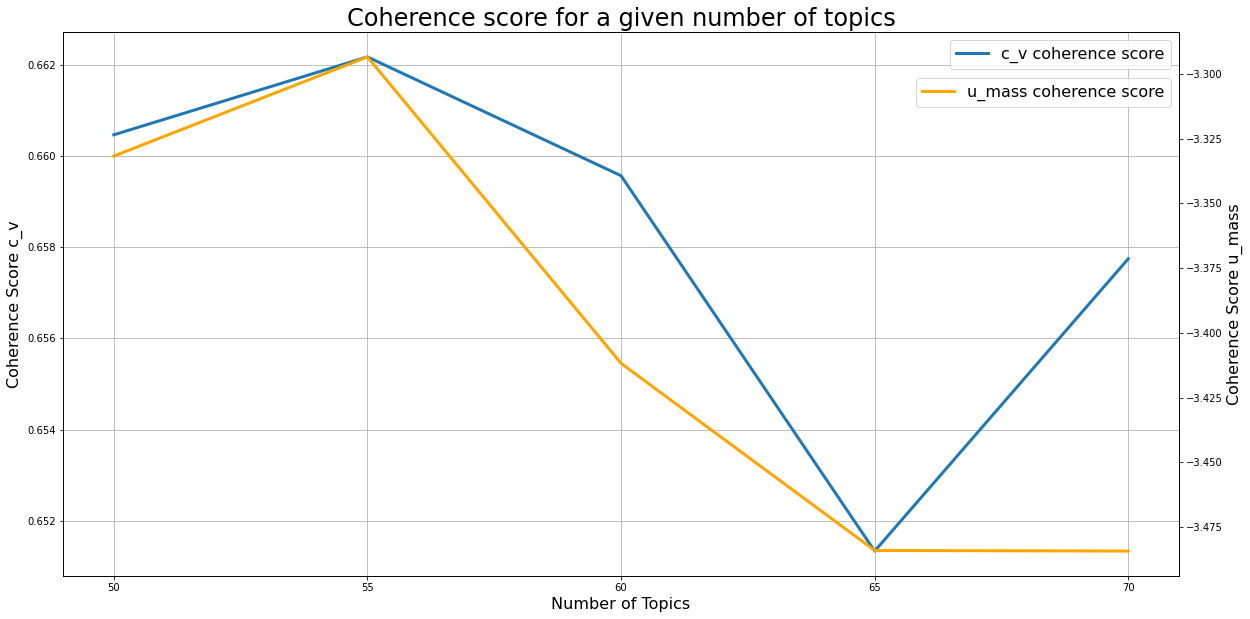

In [78]:
coherence_plot(coherence_scores_cv, coherence_scores_umass, n_topics_list)

In [10]:
alphas = [0.1, 0.5, 0.9, 0.95, 1]
betas = [0.01, 0.05, 0.1, 0.5]

In [15]:
coherence_scores_cv, coherence_scores_umass = get_coherence_scores_tune(S_final,
                                                                        spark,
                                                                        path_data,
                                                                        55,
                                                                        alphas,
                                                                        betas,
                                                                        texts,
                                                                        corpus,
                                                                        id2word,
                                                                        12)

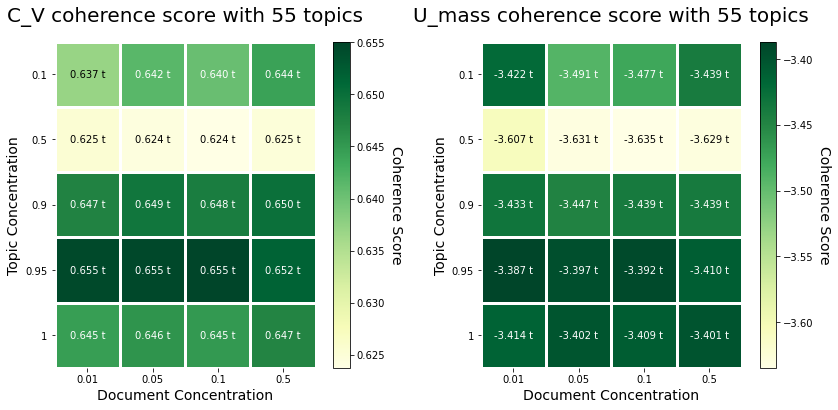

In [19]:
coherence_plot_tune(55, coherence_scores_cv, coherence_scores_umass, alphas, betas)

# 

# Check that it is possible to recover vocabulary size from sparkdf.json

In [8]:
min, max = 55, 100

In [10]:
np.arange(min, max, 5)

array([55, 60, 65, 70, 75, 80, 85, 90, 95])

In [3]:
spark, conf = create_spark_session(n_jobs=1, executor_mem=4, driver_mem=16)

In [4]:
df_load = spark.read.json('/dlabdata1/youtube_large/olam/data/test/model/sparkdf.json')

In [8]:
df_load.show(5)

+--------------------+-------+
|            features|     id|
+--------------------+-------+
|[[40, 2228, 6815,...|4100096|
|[[2, 40, 2228, 68...|4100097|
|[[40, 6815, 7591,...|4100098|
|[[40, 1114, 1182,...|4100099|
|[[1114, 1289, 135...|4100100|
+--------------------+-------+
only showing top 5 rows



In [5]:
data = []

In [6]:
for i, row in enumerate(df_load.collect()):
    
    features = row['features']
    data.append([row['id'], SparseVector(
        features['size'], features['indices'], features['values'])])
    
    if i == 0:
        vocabSize = features['size']

In [7]:
data

[[4100096,
  SparseVector(46481, {40: 1.0, 2228: 1.0, 6815: 1.0, 7591: 1.0, 11045: 1.0, 14484: 2.0, 15190: 1.0, 17006: 1.0, 18366: 1.0, 18771: 1.0, 19920: 1.0, 22228: 1.0, 22915: 1.0, 23184: 2.0, 23256: 1.0, 23612: 4.0, 23908: 1.0, 25216: 1.0, 25876: 1.0, 28693: 2.0, 29481: 2.0, 30573: 1.0, 32038: 1.0, 34864: 1.0, 35495: 1.0, 36251: 1.0, 38508: 1.0, 40826: 1.0, 42435: 5.0, 42740: 1.0, 45296: 1.0, 46212: 1.0})],
 [4100097,
  SparseVector(46481, {2: 1.0, 40: 1.0, 2228: 1.0, 6815: 1.0, 7591: 1.0, 11045: 1.0, 14484: 2.0, 15190: 1.0, 18366: 1.0, 19920: 1.0, 23184: 1.0, 23256: 1.0, 23612: 1.0, 23908: 1.0, 25216: 1.0, 25876: 1.0, 28693: 1.0, 29481: 2.0, 31451: 1.0, 31976: 1.0, 32038: 1.0, 34864: 1.0, 35495: 1.0, 40826: 1.0, 41101: 1.0, 42435: 4.0, 42740: 2.0, 45296: 1.0, 46212: 1.0})]]

In [ ]:
def get_vocSize(df_load):
    """
    Parameters
    ----------
    df_load: pyspark.sql.dataframe.DataFrame
        The spark dataframe generated by data_processing.py
    
    Returns
    ----------
    vocSize: int
        Size of the vocabulary
    """
    return vocSize

# cat_classifier.py

In [81]:
path_write_data = '/dlabdata1/youtube_large/olam/data/test/'
path_dataset = '/dlabdata1/youtube_large/yt_metadata_en.jsonl.gz'
n_min_sub = 100000
n_min_views = 10000
n_top_vid_per_combination = 20
n_topic_tune = 55

In [53]:
set_relevant_channels = load_pickle(path_write_data + 'set_relevant_channels.pickle')

In [54]:
set_relevant_channels_classifier = get_relevant_channels(n_min_sub)

In [56]:
df_relevant_vids = get_dataframe_relevant_vid(path_dataset, set_relevant_channels_classifier, n_min_views)

In [57]:
len(df_relevant_vids)

16427559

In [58]:
type(df_relevant_vids)

pandas.core.frame.DataFrame

In [59]:
df_relevant_vids_classifier = get_relevant_vid_classifier(df_relevant_vids, n_top_vid_per_combination)

In [60]:
len(df_relevant_vids_classifier)

12528245

In [61]:
def get_data_for_classifier(id2word_final, set_relevant_vids_classifier, stop_words, tokenizer, stemmer):
    """
    Parameters
    ----------
    id2word_final : dict
    set_relevant_vids_classifier : set
    stop_words :
    tokenizer :
    stemmer :


    Returns
    ----------
    S : sparse matrix
    groundtruth : list

    """

    # Get the vocabulary of the TM model
    vocab = list(id2word_final.values())

    # we need word2id in order to be able to match the token to its index in the vocabulary
    word2id = {v: k for k, v in id2word_final.items()}

    S = dok_matrix((len(set_relevant_vids_classifier), len(vocab)), dtype=np.uint8)
    groundtruth = []
    i_vid = 0

    with gzip.open('/dlabdata1/youtube_large/yt_metadata_en.jsonl.gz', 'rb') as f:

        for i, line in enumerate(f):

            if i in set_relevant_vids_classifier:

                # line is a str dict, video is the dict corresponding to the str dict
                video = json.loads(line)

                # Get the tokens for each video and theirs number of occurrences
                freq_tokens_per_video = get_freq_tokens_per_video(video, False, stop_words, tokenizer, stemmer)

                # For each video, create a underlying dictionary for filling the sparse matrix efficiently
                dict_freq_tokens_for_sparse_matrix = fill_underlying_dict(freq_tokens_per_video, word2id, i_vid)

                # Need to check that the video contains token from the reduced vocabulary
                if dict_freq_tokens_for_sparse_matrix != {}:
                    # Update the Sparse Matrix
                    dict.update(S, dict_freq_tokens_for_sparse_matrix)
                    i_vid += 1

                    # Get groundtruth values
                    groundtruth.append(video['categories'])

    # Save last sparse matrix
    S = S.tocsr()
    S = remove_zero_rows(S)

    return S, groundtruth


In [62]:
index_balanced_videos_classifier = get_balanced_data_for_classifier(df_relevant_vids_classifier)

<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>


In [63]:
len(index_balanced_videos_classifier)

75299

In [64]:
stop_words = set(stopwords.words('english'))
tokenizer = RegexpTokenizer(r'\w+')
stemmer = SnowballStemmer(language='english')

In [65]:
id2word_final = load_pickle(path_write_data + 'id2word_final.pickle')

In [66]:
S, groundtruth = get_data_for_classifier(id2word_final, index_balanced_videos_classifier, stop_words, tokenizer, stemmer)

In [67]:
spark, conf = create_spark_session(4, 4, 64)

In [68]:
df = get_data_for_tm(S, spark)

In [69]:
S.shape[0]

74977

In [70]:
type(df)

pyspark.sql.dataframe.DataFrame

In [71]:
n_topics_array = np.arange(5, 15 + 1, 5)

In [72]:
list_train_idx, list_test_idx, list_val_idx = split_train_test_val(
    path_write_data, train_size=0.8, n_docs=len(groundtruth))

In [91]:
reg_coefs = np.logspace(0, 1, num=20, base=100) / 100
accuracies = []

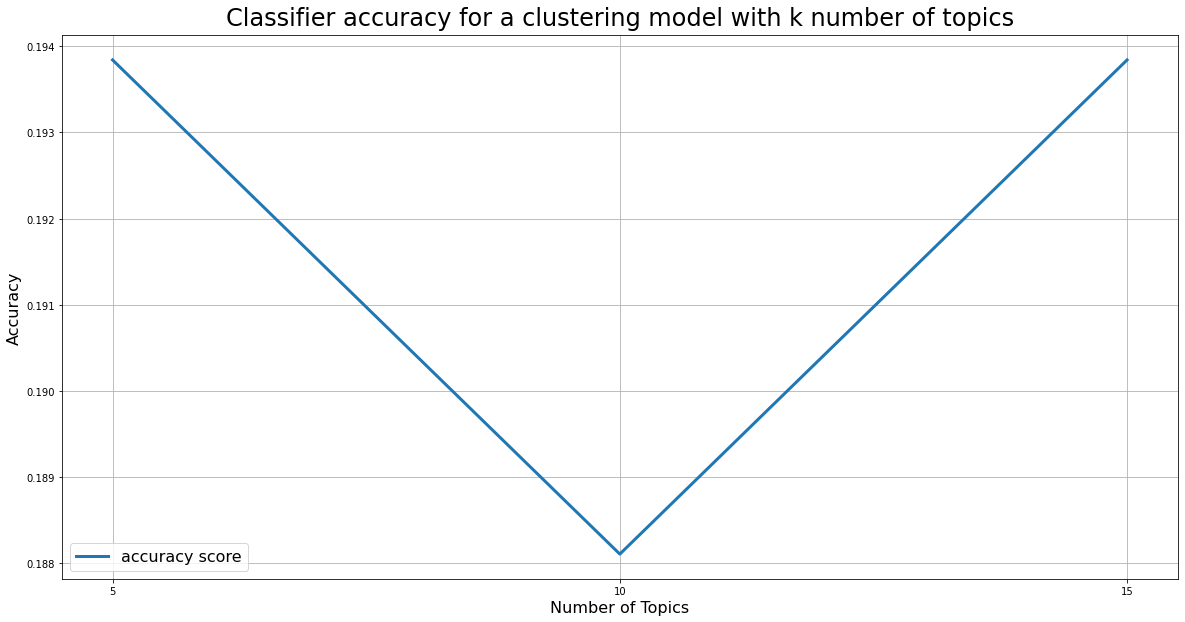

In [92]:
for n_topics in n_topics_array:

    path_doc_topic_matrix = path_write_data + 'matrices/doc_topic_mat/doc_topic_mat_ntopic' + str(n_topics) + '.npz'

    if os.path.isfile(path_doc_topic_matrix):
        doc_topic_matrix = scipy.sparse.load_npz(path_doc_topic_matrix)
    else:
        path_model = path_write_data + 'models/model_' + str(n_topics)
        doc_topic_matrix = get_doc_topic_matrices(path_model, df, n_docs=S.shape[0], vocabSize=len(id2word_final))

        scipy.sparse.save_npz(path_doc_topic_matrix, doc_topic_matrix)

    accuracy = classifier(doc_topic_matrix, groundtruth, reg_coefs, list_train_idx, list_test_idx, list_val_idx)
    
    accuracies.append(accuracy)

plot_accuracy_classifier(accuracies, n_topics_array)

In [86]:
accuracies

[0.1938434829059829, 0.1938434829059829, 0.1938434829059829]

In [77]:
path_doc_topic_matrix

'/dlabdata1/youtube_large/olam/data/test/matrices/doc_topic_mat/doc_topic_mat_ntopic15.npz'

In [88]:
alphas = [0.1, 0.5]
betas = [0.01, 0.05]

accuracies = []

In [89]:
for alpha in alphas:

    accuracies_alpha = []

    for beta in betas:

        # Get the data features for the classifier
        path_doc_topic_matrix = path_write_data + 'matrices/doc_topic_mat/doc_topic_mat_ntopic' + str(
            n_topic_tune) + '_alpha' + str(alpha) + '_beta' + str(beta) + '.npz'

        # If the data doesn't exists yet, generate it
        if os.path.isfile(path_doc_topic_matrix):
            doc_topic_matrix = scipy.sparse.load_npz(path_doc_topic_matrix)
        else:
            path_model = path_write_data + 'models/tune/model_ntopics' + str(n_topic_tune) + '_alpha' + str(alpha) + '_beta' + str(beta)
            doc_topic_matrix = get_doc_topic_matrices(path_model, df, n_docs=S.shape[0], vocabSize=len(id2word_final))

            scipy.sparse.save_npz(path_doc_topic_matrix, doc_topic_matrix)

        accuracy = classifier(doc_topic_matrix, groundtruth, reg_coefs, list_train_idx, list_test_idx,
                              list_val_idx)
        accuracies_alpha.append(accuracy)

    accuracies.append(accuracies_alpha)

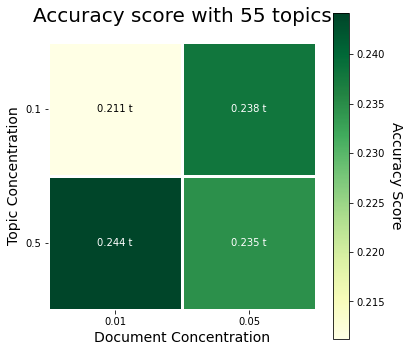

In [90]:
plot_accuracy_classifier_tune(accuracies, alphas, betas)

In [93]:
groundtruth = load_pickle(path_write_data + 'groundtruth.pickle')

In [94]:
len(groundtruth)

74934

In [95]:
index_train_test_val_clasifier = load_pickle(path_write_data + 'index_train_test_val_clasifier.pickle')

In [96]:
len(index_train_test_val_clasifier)

74957

In [8]:
path_data = '/dlabdata1/youtube_large/olam/data/test/'

In [9]:
S_final = scipy.sparse.load_npz(path_data + 'matrices/S_final.npz')
id2word = load_pickle(path_data + 'id2word_final.pickle')

In [11]:
texts = get_texts(S_final, id2word)

In [10]:
S_final.shape

(3892649, 46481)

In [ ]:
corpus = get_corpus(S_final)

In [4]:
s1 = scipy.sparse.load_npz(path_data + 'matrices/doc_topic_mat/doc_topic_mat_ntopic5.npz')

In [5]:
s2 = scipy.sparse.load_npz(path_data + 'matrices/doc_topic_mat/doc_topic_mat_ntopic10.npz')

In [6]:
s1

<74934x46481 sparse matrix of type '<class 'numpy.float64'>'
	with 374670 stored elements in Compressed Sparse Row format>

In [9]:
s2[0, 0]

0.008043278068276911

In [8]:
s1[0, 0]

0.01328500603151037